In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

In [2]:
import os

DATA_DIR = '/kaggle/input/gan-getting-started'
print(os.listdir(DATA_DIR))

['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']


In [3]:
print(os.listdir(DATA_DIR+'/monet_jpg')[:10])

['f4413e97bd.jpg', '7341d96c1d.jpg', 'de6f71b00f.jpg', '99d94af5dd.jpg', '99a51d3e25.jpg', 'd05cab011d.jpg', '4e05523825.jpg', 'c68c52e8fc.jpg', '40d7d18ad3.jpg', 'f96a8de9f3.jpg']


In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [7]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

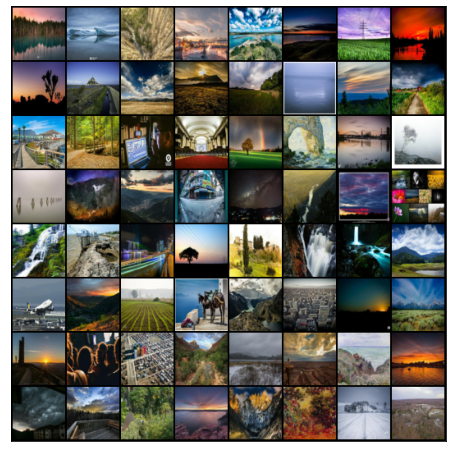

In [9]:
show_batch(train_dl)

#GPU device

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
import torch.nn as nn

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


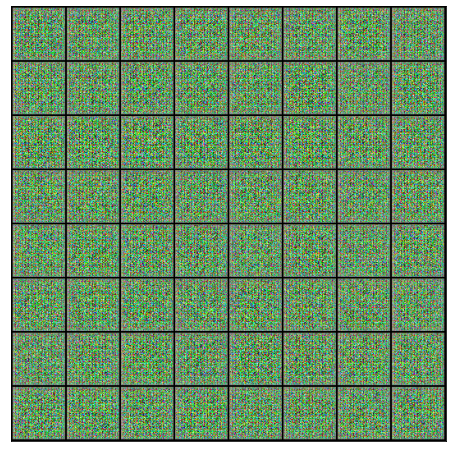

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

In [20]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [21]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [22]:
from torchvision.utils import save_image

In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


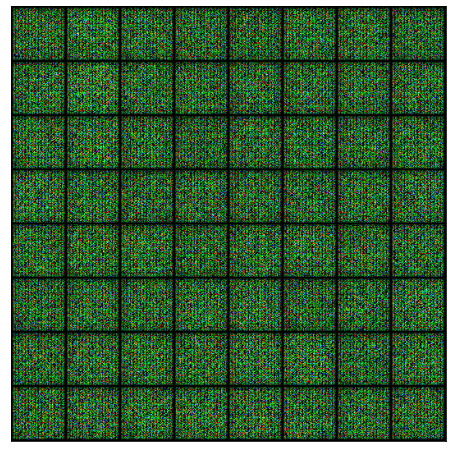

In [26]:
save_samples(0, fixed_latent)

In [27]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [28]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [29]:
lr = 0.0002
epochs = 50

In [30]:
history = fit(epochs, lr)

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 5.7085, loss_d: 0.2615, real_score: 0.8577, fake_score: 0.0845
Saving generated-images-0001.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 0.7116, loss_d: 0.6148, real_score: 0.6286, fake_score: 0.0738
Saving generated-images-0002.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 3.8596, loss_d: 0.9949, real_score: 0.8245, fake_score: 0.5193
Saving generated-images-0003.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 2.0995, loss_d: 0.5968, real_score: 0.7161, fake_score: 0.2007
Saving generated-images-0004.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 4.4972, loss_d: 0.6951, real_score: 0.8918, fake_score: 0.3990
Saving generated-images-0005.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 2.0199, loss_d: 0.5516, real_score: 0.6889, fake_score: 0.1045
Saving generated-images-0006.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 1.5698, loss_d: 1.0773, real_score: 0.4099, fake_score: 0.0452
Saving generated-images-0007.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 2.3003, loss_d: 0.5464, real_score: 0.6818, fake_score: 0.1057
Saving generated-images-0008.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 2.8492, loss_d: 0.5254, real_score: 0.7988, fake_score: 0.2397
Saving generated-images-0009.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 3.3498, loss_d: 0.3301, real_score: 0.8605, fake_score: 0.1498
Saving generated-images-0010.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 5.1609, loss_d: 0.9576, real_score: 0.8632, fake_score: 0.5053
Saving generated-images-0011.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 2.3408, loss_d: 0.5217, real_score: 0.8173, fake_score: 0.2433
Saving generated-images-0012.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 4.3297, loss_d: 0.5803, real_score: 0.8159, fake_score: 0.2892
Saving generated-images-0013.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 2.2923, loss_d: 0.6394, real_score: 0.6718, fake_score: 0.1807
Saving generated-images-0014.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 2.4764, loss_d: 1.2767, real_score: 0.3621, fake_score: 0.0214
Saving generated-images-0015.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 3.0613, loss_d: 0.8642, real_score: 0.4837, fake_score: 0.0229
Saving generated-images-0016.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 2.2941, loss_d: 0.5587, real_score: 0.6299, fake_score: 0.0332
Saving generated-images-0017.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 2.8663, loss_d: 0.5459, real_score: 0.6487, fake_score: 0.0408
Saving generated-images-0018.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 4.8533, loss_d: 0.4460, real_score: 0.9066, fake_score: 0.2674
Saving generated-images-0019.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 3.2364, loss_d: 0.3531, real_score: 0.8345, fake_score: 0.1339
Saving generated-images-0020.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 2.1304, loss_d: 0.4901, real_score: 0.7130, fake_score: 0.1105
Saving generated-images-0021.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.4166, loss_d: 0.5021, real_score: 0.8772, fake_score: 0.2868
Saving generated-images-0022.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 7.9116, loss_d: 1.3383, real_score: 0.9866, fake_score: 0.6925
Saving generated-images-0023.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 3.9374, loss_d: 0.4901, real_score: 0.7989, fake_score: 0.2084
Saving generated-images-0024.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 3.5304, loss_d: 0.6461, real_score: 0.8393, fake_score: 0.3353
Saving generated-images-0025.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 2.2064, loss_d: 1.3372, real_score: 0.3303, fake_score: 0.0076
Saving generated-images-0026.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 2.4608, loss_d: 0.7430, real_score: 0.5554, fake_score: 0.0216
Saving generated-images-0027.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 5.3535, loss_d: 0.5095, real_score: 0.8855, fake_score: 0.2922
Saving generated-images-0028.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.1724, loss_d: 0.4229, real_score: 0.8426, fake_score: 0.1805
Saving generated-images-0029.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 5.0096, loss_d: 0.7372, real_score: 0.8847, fake_score: 0.4170
Saving generated-images-0030.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 0.7396, loss_d: 1.5221, real_score: 0.2794, fake_score: 0.0086
Saving generated-images-0031.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 6.6217, loss_d: 0.8160, real_score: 0.9755, fake_score: 0.5137
Saving generated-images-0032.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.3758, loss_d: 0.5118, real_score: 0.9501, fake_score: 0.3475
Saving generated-images-0033.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 4.0639, loss_d: 0.6061, real_score: 0.7790, fake_score: 0.2585
Saving generated-images-0034.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 4.2878, loss_d: 0.7611, real_score: 0.7961, fake_score: 0.3727
Saving generated-images-0035.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 3.7234, loss_d: 0.2339, real_score: 0.8636, fake_score: 0.0752
Saving generated-images-0036.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 4.3185, loss_d: 0.6308, real_score: 0.7967, fake_score: 0.2994
Saving generated-images-0037.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 4.1336, loss_d: 0.2537, real_score: 0.9239, fake_score: 0.1503
Saving generated-images-0038.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.8131, loss_d: 0.3147, real_score: 0.8447, fake_score: 0.1180
Saving generated-images-0039.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 3.4136, loss_d: 0.5204, real_score: 0.8125, fake_score: 0.2406
Saving generated-images-0040.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 2.0509, loss_d: 0.5446, real_score: 0.6295, fake_score: 0.0401
Saving generated-images-0041.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 2.1137, loss_d: 0.6062, real_score: 0.6941, fake_score: 0.1778
Saving generated-images-0042.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 5.1565, loss_d: 1.0205, real_score: 0.9124, fake_score: 0.5481
Saving generated-images-0043.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 3.8660, loss_d: 0.4471, real_score: 0.9519, fake_score: 0.2940
Saving generated-images-0044.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 2.8532, loss_d: 0.3981, real_score: 0.7887, fake_score: 0.1139
Saving generated-images-0045.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 5.9452, loss_d: 0.3865, real_score: 0.9349, fake_score: 0.2430
Saving generated-images-0046.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 3.1958, loss_d: 0.2267, real_score: 0.8728, fake_score: 0.0762
Saving generated-images-0047.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 1.5802, loss_d: 0.4573, real_score: 0.7124, fake_score: 0.0714
Saving generated-images-0048.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.1588, loss_d: 0.2140, real_score: 0.9404, fake_score: 0.1334
Saving generated-images-0049.png


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 2.6025, loss_d: 0.4257, real_score: 0.7181, fake_score: 0.0445
Saving generated-images-0050.png


In [31]:
losses_g, losses_d, real_scores, fake_scores = history

In [32]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [33]:
from IPython.display import Image

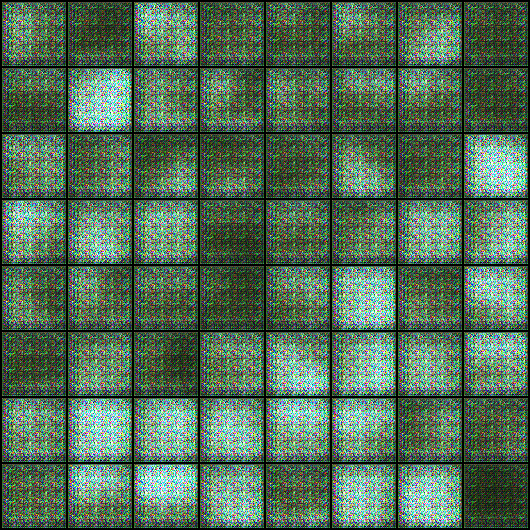

In [34]:
Image('./generated/generated-images-0001.png')

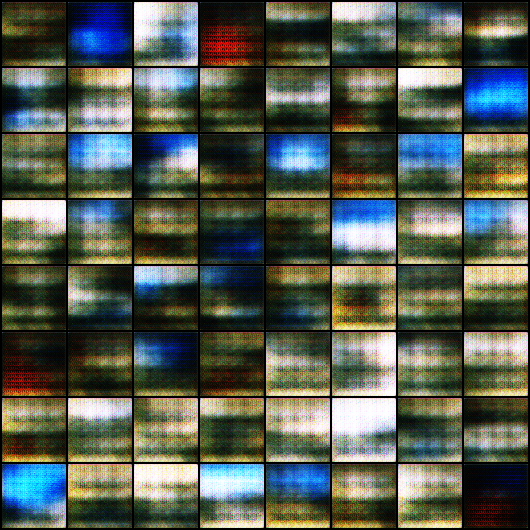

In [35]:
Image('./generated/generated-images-0005.png')

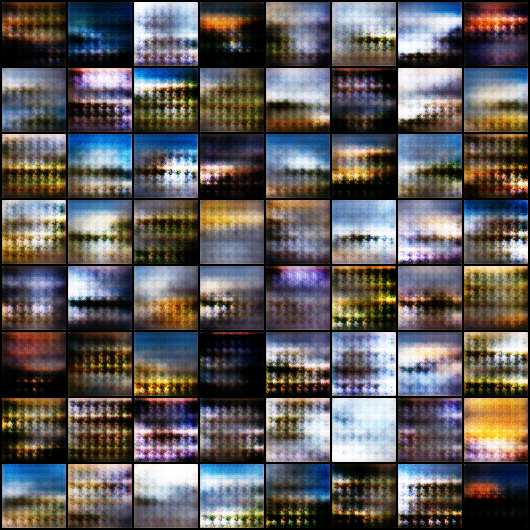

In [36]:
Image('./generated/generated-images-0010.png')

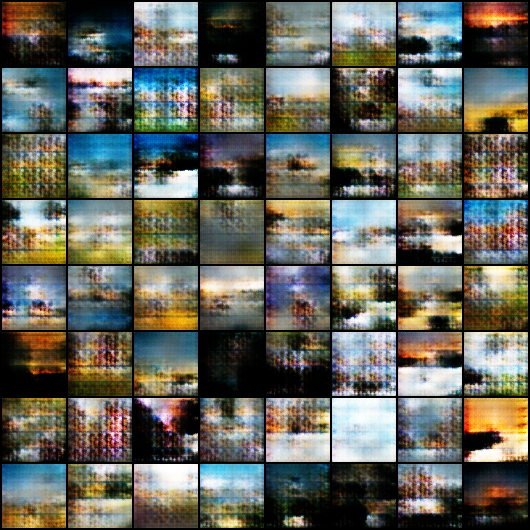

In [37]:
Image('./generated/generated-images-0020.png')

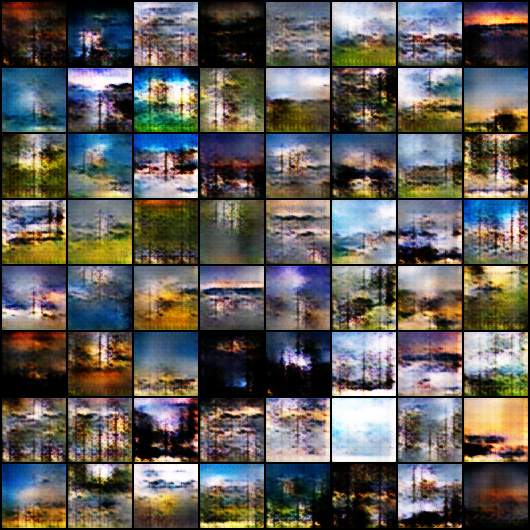

In [38]:
Image('./generated/generated-images-0025.png')

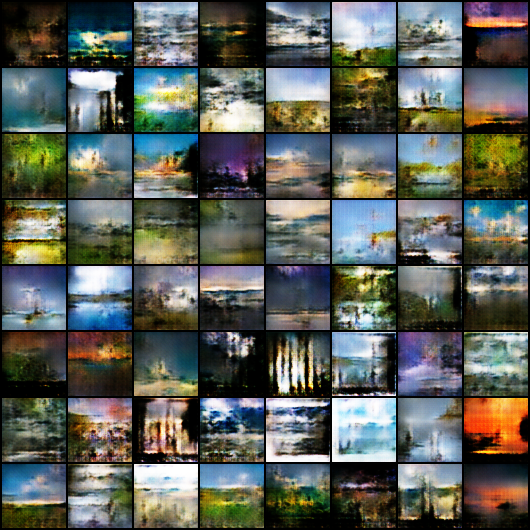

In [39]:
Image('./generated/generated-images-0050.png')

In [40]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [41]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('out','rb').read()
data_url = "gans_training.avi" + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
      </video>
""" % data_url)

FileNotFoundError: [Errno 2] No such file or directory: 'out'

In [ ]:
import urllib
dwn_link = 'gans_training.avi'

file_name = 'gans_training.avi' 
urllib.retrieve(dwn_link, file_name)

In [ ]:
gans-training.avi


In [ ]:
video = cv2.VideoCapture(0)
   
# We need to check if camera
# is opened previously or not
if (video.isOpened() == False): 
    print("Error reading video file")
  
# We need to set resolutions.
# so, convert them from float to integer.
frame_width = int(video.get(3))
frame_height = int(video.get(4))
   
size = (frame_width, frame_height)
   
# Below VideoWriter object will create
# a frame of above defined The output 
# is stored in 'filename.avi' file.
result = cv2.VideoWriter('gans-training.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)
    
while(True):
    ret, frame = video.read()
  
    if ret == True: 
  
        # Write the frame into the
        # file 'filename.avi'
        result.write(frame)
  
        # Display the frame
        # saved in the file
        cv2.imshow('Frame', frame)
  
        # Press S on keyboard 
        # to stop the process
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break
  
    # Break the loop
    else:
        break
  
# When everything done, release 
# the video capture and video 
# write objects
video.release()
result.release()
    
# Closes all the frames
#cv2.destroyAllWindows()
   
print("The video was successfully saved")